# **Project Topic: Scene Recognition**

In this research, we investigate the performance of three distinct pretrained models for scene recognition. Our objective is to identify the most effective model by evaluaating their acuracy and robustness. Through systematic experimentation with various training and testing methodologies, we aim to determine the optimal approach for achieving the highest recognition performance. We choose this topic because scene recognition is not only a fasinating area of computer vision but also a challenging one that pushes us to think creatively and learn beyond conventional boundaries. By exploring different models and techniques, we hope to deepen our understanding of the field while contributing meaningful insights to the problem of scene recognition.

In [ ]:
!pip install optuna

import kagglehub
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools
import optuna
import shutil
import time
import random

## **Step 1: Upload dataset**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("itsahmad/indoor-scenes-cvpr-2019")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/itsahmad/indoor-scenes-cvpr-2019/versions/1


After uploading the dataset, our next step is to analyze and understand its structure. Using the provided API call, we aim to identify the files and folders within the dataset, along with their respective names. This process will help us determine the number of image cateogries we need to correctly identify, as well as the quantity of images available per category. By gaining this insight, we can better prepare for the subsequent stages of training and testing our models.

## **Step 2: Understanding the dataset**

In [ ]:
print(os.listdir(path))  # List all files and folders in the dataset

['indoorCVPR_09annotations', 'TrainImages.txt', 'TestImages.txt', 'indoorCVPR_09']


In [ ]:
# Identifying what is a file or folder in the dataset
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"{item} is a FOLDER")
    else:
        print(f"{item} is a FILE")

indoorCVPR_09annotations is a FOLDER
TrainImages.txt is a FILE
TestImages.txt is a FILE
indoorCVPR_09 is a FOLDER


In [ ]:
image_dir = os.path.join(path, "indoorCVPR_09")  # Adjust if images are elsewhere
print(os.listdir(image_dir))  # List category folders

['Images']


In [ ]:
# Checking number of categories
category_counts = {}

for category in os.listdir(image_dir):
    category_path = os.path.join(image_dir, category)

    if os.path.isdir(category_path):  # Ensure it's a folder
        num_images = len(os.listdir(category_path))  # Count images
        category_counts[category] = num_images

# Print results
for category, count in category_counts.items():
    print(f"{category}: {count} categories")


Images: 67 categories


The dataset provides TrainImages.txt and TestImages.txt, which are a list of images, roughly 80 images per category. This represents a subset of the full dataset used for training purposes. Let's preview them.

In [ ]:
train_file = os.path.join(path, "TrainImages.txt")

with open(train_file, "r") as f:
    lines = f.readlines()

# Print the first 5 lines to check the structure
for line in lines[:5]:
    print(line.strip())

gameroom/bt_132294gameroom2.jpg
poolinside/inside_pool_and_hot_tub.jpg
winecellar/bodega_12_11_flickr.jpg
casino/casino_0512.jpg
livingroom/living58.jpg


Now, let's extract categories and count the number of images per category:

In [ ]:
# Initialize dictionary
category_counts = defaultdict(int)

# Read file and count occurrences of each category
with open(train_file, "r") as f:
    for line in f:
        category = line.strip().split('/')[0]  # Extract category name
        category_counts[category] += 1

# Sort categories by image count
sorted_counts = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)

# Print results
for category, count in sorted_counts:
    print(f"{category}: {count} images")

fastfood_restaurant: 83 images
clothingstore: 82 images
garage: 82 images
tv_studio: 82 images
bathroom: 82 images
closet: 82 images
classroom: 82 images
gym: 82 images
dining_room: 82 images
bar: 82 images
children_room: 82 images
computerroom: 82 images
auditorium: 82 images
casino: 81 images
church_inside: 81 images
florist: 81 images
bakery: 81 images
shoeshop: 81 images
studiomusic: 81 images
deli: 81 images
operating_room: 81 images
gameroom: 80 images
poolinside: 80 images
livingroom: 80 images
mall: 80 images
bookstore: 80 images
prisoncell: 80 images
airport_inside: 80 images
library: 80 images
hospitalroom: 80 images
trainstation: 80 images
greenhouse: 80 images
stairscase: 80 images
movietheater: 80 images
pantry: 80 images
artstudio: 80 images
cloister: 80 images
kindergarden: 80 images
restaurant: 80 images
concert_hall: 80 images
lobby: 80 images
buffet: 80 images
bowling: 80 images
nursery: 80 images
winecellar: 79 images
corridor: 79 images
waitingroom: 79 images
grocer

And finally, plot the bar chart for a better visualization:

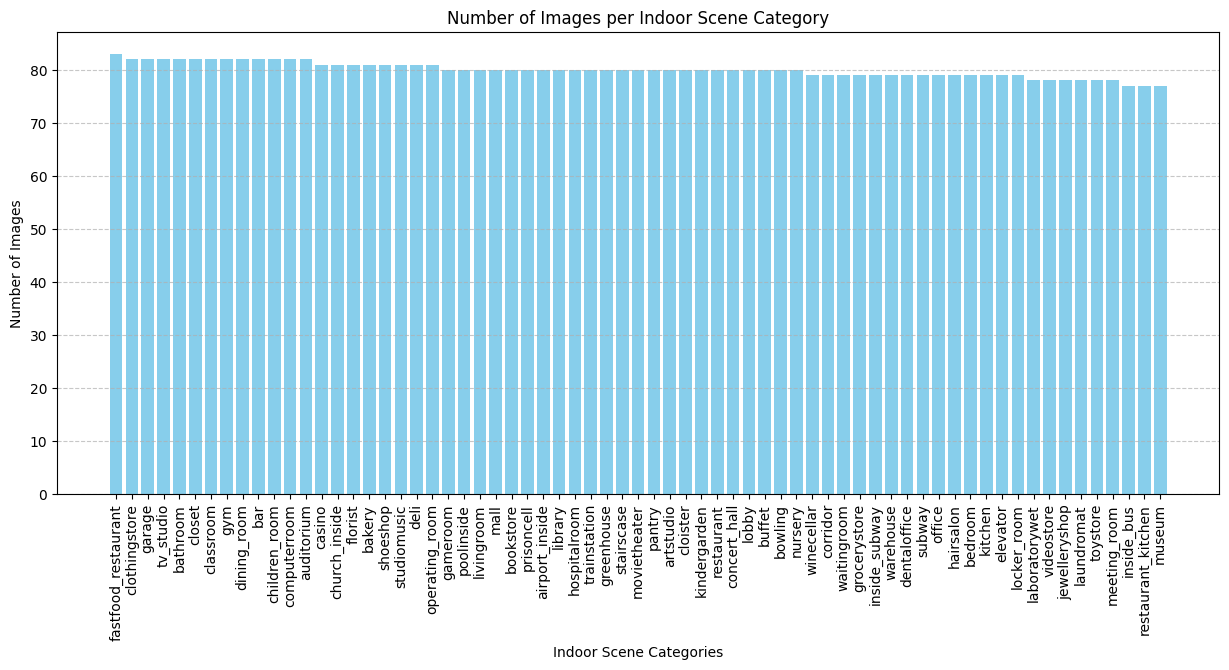

In [ ]:
# Extract sorted category names and counts
categories, counts = zip(*sorted_counts)

# Plot
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="skyblue")
plt.xlabel("Indoor Scene Categories")
plt.ylabel("Number of Images")
plt.title("Number of Images per Indoor Scene Category")
plt.xticks(rotation=90)  # Rotate labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the chart
plt.show()


So there are 67 categories in total that we need to have our model correctly identify.

## **Step 3: Defining Model Training Functions**

Here we do a deep learning model using PyTorch, optimizing it with Adam while incorporating a learning rate scheduler and early stopping to improve validation accuracy. It tracks training and validation accuracy over epochs, stopping early if no improvement is observed.

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, best_params, num_epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Use best hyperparameters
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.1, patience=2, verbose=True
    )

    # Add early stopping
    best_val_acc = 0
    patience = 3
    patience_counter = 0

    train_acc_history, val_acc_history = [], []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        val_acc_history.append(val_accuracy)

        # Learning rate scheduler step
        scheduler.step(val_accuracy)

        # Early stopping logic
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0  # Reset counter if improvement occurs
        else:
            patience_counter += 1  # Increment counter if no improvement

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Train Acc: {train_accuracy:.4%} - Val Acc: {val_accuracy:.4%}")

        # Stop training if patience threshold is reached
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    training_time = time.time() - start_time
    return model, train_acc_history, val_acc_history, training_time, best_val_acc

Then we evaluate the trained model on the test dataset by computing predictions, comparing them to true labels and calculating overall test accuracy. It returns the true labels, predicted labels and test accuracy.

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    return y_true, y_pred, test_acc

And then we plot a confusion matrix to visualize the model's classification perfomance.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

## **Step 4: Data Processing and Splitting the data into training, validation and test sets**

In this step, we organize an image dataset by splitting it into training, validation and test sets while preserving category structures. It reads image file lists, shuffles and partitions them based on predefined ratios, creates necessary dictionaries and copies images to their respective folders.

In [ ]:
# Define file paths
train_file = os.path.join(path, "TrainImages.txt")
test_file = os.path.join(path, "TestImages.txt")
input_folder = os.path.join(path, "indoorCVPR_09/Images")
output_folder = "truncated_dataset"

# Create output directories
train_output = os.path.join(output_folder, "train")
val_output = os.path.join(output_folder, "val")
test_output = os.path.join(output_folder, "test")
os.makedirs(train_output, exist_ok=True)
os.makedirs(val_output, exist_ok=True)
os.makedirs(test_output, exist_ok=True)

def organize_dataset(input_folder, train_file, test_file, output_folder, val_split=0.2):

    # Read train and test files
    with open(train_file, 'r') as f:
        train_images = [line.strip() for line in f.readlines()]

    with open(test_file, 'r') as f:
        test_images = [line.strip() for line in f.readlines()]

    # Split train images into train and validation
    train_imgs, val_imgs = train_test_split(train_images, test_size=val_split, random_state=42)

    # Function to copy images
    def copy_images(image_list, target_dir):
        for img_path in image_list:
            category = img_path.split('/')[0]
            filename = img_path.split('/')[-1]

            # Create category directory if it doesn't exist
            category_dir = os.path.join(target_dir, category)
            os.makedirs(category_dir, exist_ok=True)

            # Copy image
            src_path = os.path.join(input_folder, img_path)
            dst_path = os.path.join(category_dir, filename)
            shutil.copy2(src_path, dst_path)

    # Copy images to respective directories
    print("Copying training images...")
    copy_images(train_imgs, train_output)

    print("Copying validation images...")
    copy_images(val_imgs, val_output)

    print("Copying test images...")
    copy_images(test_images, test_output)

    print("Dataset organization complete!")

# Use the function
input_folder = os.path.join(path, "indoorCVPR_09/Images")
train_file = os.path.join(path, "TrainImages.txt")
test_file = os.path.join(path, "TestImages.txt")
output_folder = "dataset"

organize_dataset(input_folder, train_file, test_file, output_folder)

def organize_full_dataset(input_folder, output_folder="full_dataset", train_split=0.7, val_split=0.2):
    """
    Organizes the complete dataset into train/val/test splits while maintaining category structure.
    Args:
        input_folder: Path to input folder containing category subfolders
        output_folder: Path to output folder
        train_split: Percentage of data for training (default: 0.7)
        val_split: Percentage of data for validation (default: 0.2)
        (test_split will be the remaining: 0.1)
    """
    # Create output directories
    train_dir = os.path.join(output_folder, "train")
    val_dir = os.path.join(output_folder, "val")
    test_dir = os.path.join(output_folder, "test")

    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)

    # Get all categories
    categories = [d for d in os.listdir(input_folder)
                 if os.path.isdir(os.path.join(input_folder, d))]

    print(f"Found {len(categories)} categories")

    # Process each category
    for category in categories:
        print(f"Processing category: {category}")

        # Create category directories in each split
        category_dirs = {
            'train': os.path.join(train_dir, category),
            'val': os.path.join(val_dir, category),
            'test': os.path.join(test_dir, category)
        }

        for dir_path in category_dirs.values():
            os.makedirs(dir_path, exist_ok=True)

        # Get all images in the category
        category_input_dir = os.path.join(input_folder, category)
        images = [f for f in os.listdir(category_input_dir)
                 if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Shuffle images
        random.seed(42)  # for reproducibility
        random.shuffle(images)

        # Calculate split indices
        n_images = len(images)
        n_train = int(n_images * train_split)
        n_val = int(n_images * val_split)

        # Split images
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]

        # Copy images to respective splits
        for split_name, split_images in [
            ('train', train_images),
            ('val', val_images),
            ('test', test_images)
        ]:
            for image in split_images:
                src_path = os.path.join(category_input_dir, image)
                dst_path = os.path.join(category_dirs[split_name], image)
                shutil.copy2(src_path, dst_path)

    print("Full dataset organization complete!")
    print(f"Split ratios - Train: {train_split:.1%}, Val: {val_split:.1%}, Test: {(1-train_split-val_split):.1%}")

# Use the function to create the full dataset with splits
input_folder = os.path.join(path, "indoorCVPR_09/Images")
organize_full_dataset(input_folder, output_folder="full_dataset", train_split=0.7, val_split=0.2)

Copying training images...
Copying validation images...
Copying test images...
Dataset organization complete!
Found 67 categories
Processing category: tv_studio
Processing category: locker_room
Processing category: inside_subway
Processing category: buffet
Processing category: dentaloffice
Processing category: bedroom
Processing category: shoeshop
Processing category: jewelleryshop
Processing category: warehouse
Processing category: bookstore
Processing category: prisoncell
Processing category: mall
Processing category: stairscase
Processing category: cloister
Processing category: children_room
Processing category: classroom
Processing category: church_inside
Processing category: studiomusic
Processing category: movietheater
Processing category: greenhouse
Processing category: casino
Processing category: office
Processing category: inside_bus
Processing category: concert_hall
Processing category: fastfood_restaurant
Processing category: videostore
Processing category: pantry
Processing

This is where we define image transformations for training and evaluation, including resizing, normalization, and data augmentation for training (random flipping, rotation, and cropping). After that, we load the image datasets from specified directories using these transformations and create DataLoader objects for batch processing. Lastly, we retrieve class names from the training dataset.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root="truncated_dataset/train", transform=train_transform)
val_dataset = datasets.ImageFolder(root="truncated_dataset/val", transform=eval_transform)
test_dataset = datasets.ImageFolder(root="truncated_dataset/test", transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset.classes

## **Step 4.5 Hyperparemeter Tuning**

Here we define an Optuna objective function for hyperparameter tuning for the models. It optimizes learning rate, weight decay, dropout rate, batch size, updates DataLoaders accordingly, and initializes a Timm-based pretrained model with dynamic dropout. The models are trained for 5 epochs, using Adam optimizer, learning rate scheduling and early stopping based on validation accuracy. During training, Optuna tracks performance, and trials that perform poorly are pruned early to speed up the search. After each trial, CUDA memory is cleared if available to prevent memory issues. The function returns the best validation accuracy for hyperparameter optimization.

In [ ]:
def create_objective(model_architecture):
    def objective(trial):
        # Hyperparameters to tune
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        batch_size = trial.suggest_int('batch_size', 16, 64, step=16)

        # Update dataloaders with new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Create model with updated dropout
        model = timm.create_model(
            model_architecture,
            pretrained=True,
            num_classes=len(class_names),
            drop_rate=dropout_rate,
            drop_path_rate=dropout_rate/2
        )

        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.1, patience=2, verbose=True
        )

        # Training loop
        best_val_acc = 0
        patience_counter = 0
        patience = 3

        for epoch in range(5):  # Reduced epochs for faster optimization
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Validation phase
            model.eval()
            val_correct, val_total = 0, 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    val_correct += (outputs.argmax(1) == labels).sum().item()
                    val_total += labels.size(0)

            val_accuracy = val_correct / val_total
            scheduler.step(val_accuracy)

            # Early stopping
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

            trial.report(val_accuracy, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return best_val_acc

    return objective

## **Step 5: Vision Transformer Model Training**

Our first model is Vision Transformers (ViT) -- A transformer-based model for image recognition that processes images as sequences of patches, leveraging self-attention for feature extraction instead of convolutional layers.

In [ ]:
# For ViT
print("Optimizing Vision Transformer hyperparameters...")
vit_study = optuna.create_study(direction='maximize')
vit_objective = create_objective('vit_base_patch16_224')
vit_study.optimize(vit_objective, n_trials=10)
vit_best_params = vit_study.best_params

[I 2025-02-23 12:42:52,641] A new study created in memory with name: no-name-60e1bf1d-fab7-42cb-80c1-6ab6aba256d2


Optimizing Vision Transformer hyperparameters...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-02-23 12:46:33,905] Trial 0 finished with value: 0.8171641791044776 and parameters: {'learning_rate': 3.0912737020290655e-05, 'weight_decay': 0.00014318223056194958, 'dropout_rate': 0.12868504920416265, 'batch_size': 32}. Best is trial 0 with value: 0.8171641791044776.
[I 2025-02-23 12:50:08,070] Trial 1 finished with value: 0.832089552238806 and parameters: {'learning_rate': 1.3191731167743497e-05, 'weight_decay': 5.891908390108778e-05, 'dropout_rate': 0.1492977856711901, 'batch_size': 48}. Best is trial 1 with value: 0.832089552238806.
[I 2025-02-23 12:53:41,408] Trial 2 finished with value: 0.7845149253731343 and parameters: {'learning_rate': 4.332161158141652e-05, 'weight_decay': 1.2075228014676229e-06, 'dropout_rate': 0.47255556153305267, 'batch_size': 48}. Best is trial 1 with value

Epoch 1/10 - Loss: 337.4128 - Train Acc: 13.9226% - Val Acc: 46.7351%
Epoch 2/10 - Loss: 151.8849 - Train Acc: 56.1567% - Val Acc: 74.3470%
Epoch 3/10 - Loss: 82.4313 - Train Acc: 74.7435% - Val Acc: 79.8507%
Epoch 4/10 - Loss: 56.4273 - Train Acc: 82.3228% - Val Acc: 81.6231%
Epoch 5/10 - Loss: 43.4450 - Train Acc: 86.5672% - Val Acc: 82.9291%
Epoch 6/10 - Loss: 33.8324 - Train Acc: 89.4823% - Val Acc: 82.8358%
Epoch 7/10 - Loss: 28.0258 - Train Acc: 91.1847% - Val Acc: 83.3955%
Epoch 8/10 - Loss: 21.4209 - Train Acc: 93.5168% - Val Acc: 84.5149%
Epoch 9/10 - Loss: 18.4618 - Train Acc: 94.9394% - Val Acc: 84.7015%
Epoch 10/10 - Loss: 15.2495 - Train Acc: 95.5224% - Val Acc: 85.7276%
Test Accuracy: 83.73%
Classification Report for Vision Transformer (ViT):
                     precision    recall  f1-score   support

     airport_inside       0.67      0.70      0.68        20
          artstudio       0.84      0.80      0.82        20
         auditorium       0.59      0.56      0.5

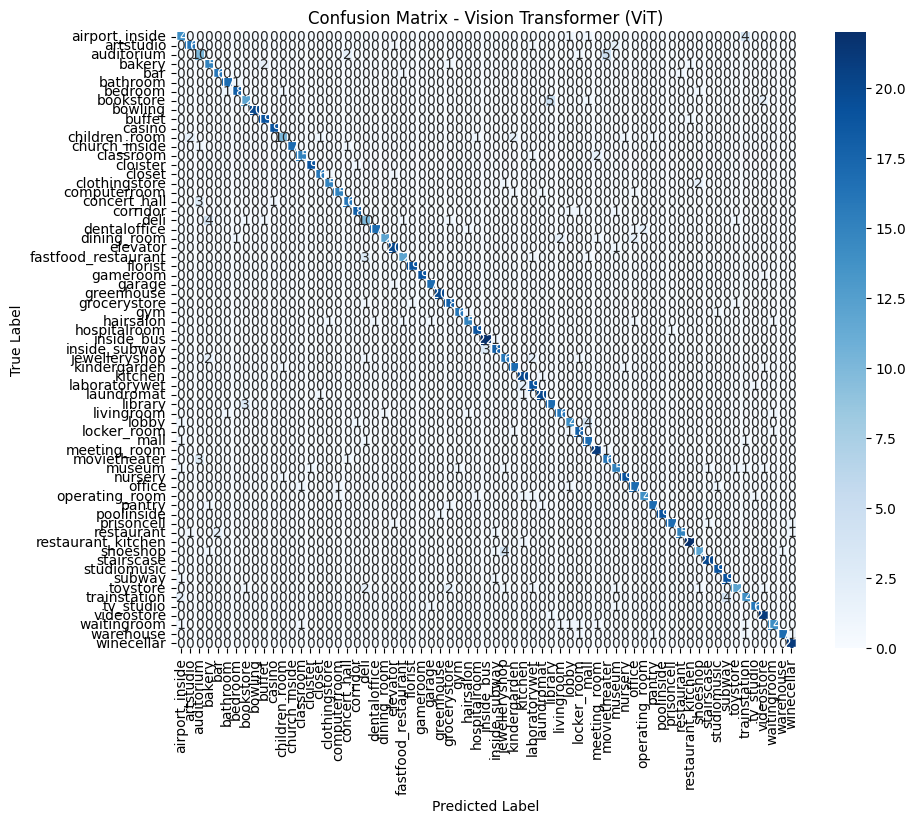

Training Time for Vision Transformer (ViT): 687.98 seconds

Accuracy for Vision Transformer (ViT): 83.73



In [ ]:
# Create data loaders with best batch size
train_loader = DataLoader(train_dataset, batch_size=vit_best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=vit_best_params['batch_size'], shuffle=False)

vit_model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=len(class_names),
    drop_rate=vit_best_params['dropout_rate'],
    drop_path_rate=vit_best_params['dropout_rate']/2
)

vit_model, vit_train_acc_history, vit_val_acc_history, vit_time, vit_val_acc = train_model(vit_model, train_loader, val_loader, vit_best_params, num_epochs=10)

# Evaluate
y_true, y_pred, vit_test_acc = evaluate_model(vit_model, test_loader)

# Print classification report
print("Classification Report for Vision Transformer (ViT):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names, "Vision Transformer (ViT)")

print(f"Training Time for Vision Transformer (ViT): {vit_time:.2f} seconds\n")
print(f"Accuracy for Vision Transformer (ViT): {vit_test_acc:.2f}\n")

# Free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

From the results of the Vision Transformer (ViT) model, we observe that the model achieved a solid test accuracy of 83.73% and a reasonable treaining time of 687.98 seconds, suggesting a balanced performance.


---

Top 3 best performing categories:
1. Bowling
2. Casino
3. Florist


---
Top 3 worst performing categories:
1. Deli
2. Toystore
3. Children's Room


## **Step 6: Convnext Model Training**

Second model is ConvNeXt -- A modernized CNN architecture inspired by ViTs, desgined with ResNet-like structures but optimized with dept-wise convolutions and LayerNorm for improved efficiency and accuracy.

In [ ]:
# For ConvNeXt
print("Optimizing ConvNeXt hyperparameters...")
convnext_study = optuna.create_study(direction='maximize')
convnext_objective = create_objective('convnext_base')
convnext_study.optimize(convnext_objective, n_trials=10)
convnext_best_params = convnext_study.best_params

[I 2025-02-23 06:52:48,450] A new study created in memory with name: no-name-7b04e41a-cb11-43b1-bc7e-9137196e1705


Optimizing ConvNeXt hyperparameters...


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-02-23 06:57:39,190] Trial 0 finished with value: 0.7658582089552238 and parameters: {'learning_rate': 0.00039011694670156776, 'weight_decay': 2.7028922147113304e-05, 'dropout_rate': 0.2825192978896618, 'batch_size': 16}. Best is trial 0 with value: 0.7658582089552238.
[I 2025-02-23 07:02:13,196] Trial 1 finished with value: 0.8777985074626866 and parameters: {'learning_rate': 2.0538038454703972e-05, 'weight_decay': 5.8469542150472965e-05, 'dropout_rate': 0.25896166416973887, 'batch_size': 48}. Best is trial 1 with value: 0.8777985074626866.
[I 2025-02-23 07:06:55,791] Trial 2 finished with value: 0.8125 and parameters: {'learning_rate': 0.0005404431517411409, 'weight_decay': 9.309615956573758e-05, 'dropout_rate': 0.45055344841512424, 'batch_size': 64}. Best is trial 1 with value: 0.877798

Epoch 1/10 - Loss: 450.4736 - Train Acc: 25.2799% - Val Acc: 72.0149%
Epoch 2/10 - Loss: 202.8767 - Train Acc: 67.4907% - Val Acc: 83.2090%
Epoch 3/10 - Loss: 119.1916 - Train Acc: 79.7108% - Val Acc: 85.1679%
Epoch 4/10 - Loss: 86.1756 - Train Acc: 84.3517% - Val Acc: 87.6866%
Epoch 5/10 - Loss: 65.8142 - Train Acc: 87.7799% - Val Acc: 87.6866%
Epoch 6/10 - Loss: 49.6428 - Train Acc: 90.6483% - Val Acc: 88.7127%
Epoch 7/10 - Loss: 39.6034 - Train Acc: 92.2108% - Val Acc: 88.6194%
Epoch 8/10 - Loss: 32.8523 - Train Acc: 94.1231% - Val Acc: 88.5261%
Epoch 9/10 - Loss: 25.7427 - Train Acc: 95.8722% - Val Acc: 87.5000%
Early stopping triggered.
Test Accuracy: 87.39%
Classification Report for ConvNext:
                     precision    recall  f1-score   support

     airport_inside       0.73      0.80      0.76        20
          artstudio       0.86      0.90      0.88        20
         auditorium       0.62      0.72      0.67        18
             bakery       0.71      0.79      0

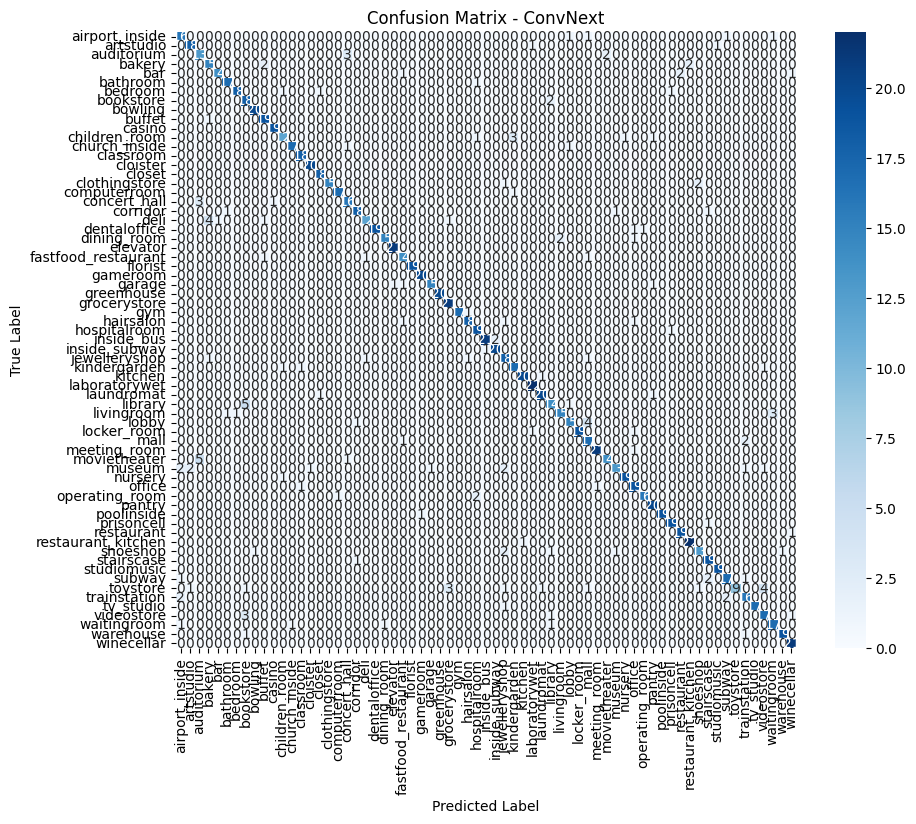

Training Time for ConvNext: 757.44 seconds

Accuracy for ConvNext: 87.39



In [ ]:
# Create data loaders with best batch size
train_loader = DataLoader(train_dataset, batch_size=convnext_best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=convnext_best_params['batch_size'], shuffle=False)

convnext_model = timm.create_model(
    "convnext_base",
    pretrained=True,
    num_classes=len(class_names),
    drop_rate=convnext_best_params['dropout_rate'],
    drop_path_rate=convnext_best_params['dropout_rate']/2
)

convnext_model, con_train_acc_history, con_val_acc_history, con_time, con_val_acc = train_model(convnext_model, train_loader, val_loader, convnext_best_params, num_epochs=10)

# Evaluate
y_true, y_pred, con_test_acc = evaluate_model(convnext_model, test_loader)

# Print classification report
print("Classification Report for ConvNext:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names, "ConvNext")

print(f"Training Time for ConvNext: {con_time:.2f} seconds\n")
print(f"Accuracy for ConvNext: {con_test_acc:.2f}\n")

# Free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

The ConvNext model shows strong performance, achieving a test accuracy of 87.39% but the training time seems to be the longest out of the 4 models with 757.44 seconds.


---


The model achieved perfect precision and recall for: Florist, Greenhouse, Cloister, Gameroom, Studiomusic.


---


Top 3 best performing categories:
1. Pantry
2. Pool Inside
3. Prison Cell


---
Top 3 worst performig categories:
1. Toystore
2. Museum
3. Jewellery Shop



## **Step 7: EfficientNet Model Training**

Third model is EfficientNet-B0 -- A lightweight CNN that uses Neural Architecture Search (NAS) to optimize depth, width and resolution scaling, achieving high accuracy with minimal computational costs.

In [ ]:
# For EfficientNet
print("Optimizing EfficientNet hyperparameters...")
efficientnet_study = optuna.create_study(direction='maximize')
efficientnet_objective = create_objective('efficientnet_b0')
efficientnet_study.optimize(efficientnet_objective, n_trials=10)
efficientnet_best_params = efficientnet_study.best_params

[I 2025-02-23 07:49:13,352] A new study created in memory with name: no-name-647baac0-e321-4c2b-ab2a-7e77bd9798ec


Optimizing EfficientNet hyperparameters...


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-02-23 07:52:41,282] Trial 0 finished with value: 0.6921641791044776 and parameters: {'learning_rate': 0.0002310560676144122, 'weight_decay': 0.00028389752657152615, 'dropout_rate': 0.2069398433978535, 'batch_size': 48}. Best is trial 0 with value: 0.6921641791044776.
[I 2025-02-23 07:56:44,011] Trial 1 finished with value: 0.18563432835820895 and parameters: {'learning_rate': 1.5760919040060842e-05, 'weight_decay': 1.985869778828419e-05, 'dropout_rate': 0.2890388865959813, 'batch_size': 16}. Best is trial 0 with value: 0.6921641791044776.
[I 2025-02-23 08:00:08,981] Trial 2 finished with value: 0.5289179104477612 and parameters: {'learning_rate': 0.00011011802924737757, 'weight_decay': 0.00030757881078313684, 'dropout_rate': 0.4904677476653361, 'batch_size': 64}. Best is trial 0 with valu

Epoch 1/10 - Loss: 279.8967 - Train Acc: 25.0000% - Val Acc: 52.3321%
Epoch 2/10 - Loss: 118.4809 - Train Acc: 62.7099% - Val Acc: 62.5000%
Epoch 3/10 - Loss: 66.2931 - Train Acc: 78.8479% - Val Acc: 68.0970%
Epoch 4/10 - Loss: 41.0827 - Train Acc: 86.6838% - Val Acc: 68.6567%
Epoch 5/10 - Loss: 26.2860 - Train Acc: 91.7910% - Val Acc: 70.3358%
Epoch 6/10 - Loss: 19.8829 - Train Acc: 93.7034% - Val Acc: 70.2425%
Epoch 7/10 - Loss: 15.0928 - Train Acc: 95.4757% - Val Acc: 69.4963%
Epoch 8/10 - Loss: 12.7354 - Train Acc: 96.0354% - Val Acc: 69.0299%
Early stopping triggered.
Test Accuracy: 67.91%
Classification Report for EfficientNet:
                     precision    recall  f1-score   support

     airport_inside       0.39      0.60      0.47        20
          artstudio       0.44      0.40      0.42        20
         auditorium       0.43      0.50      0.46        18
             bakery       0.57      0.42      0.48        19
                bar       0.60      0.33      0.43  

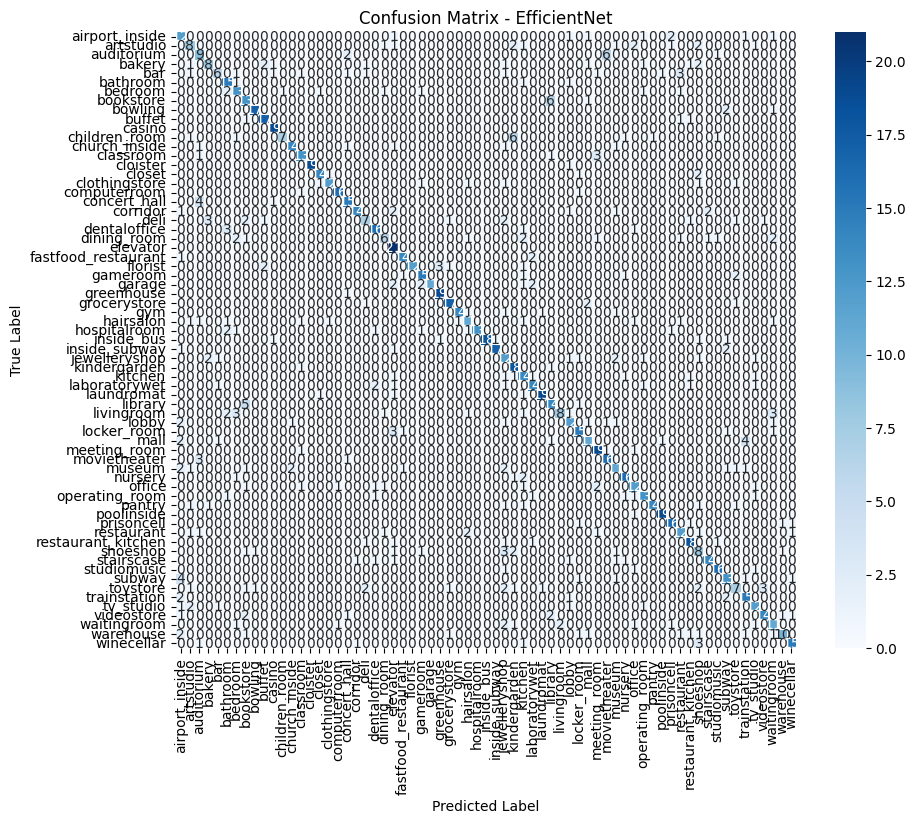

Training Time for EfficientNet: 345.81 seconds

Accuracy for EfficientNet: 67.91



In [ ]:
# Create data loaders with best batch size
train_loader = DataLoader(train_dataset, batch_size=efficientnet_best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=efficientnet_best_params['batch_size'], shuffle=False)

efficientnet_model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=len(class_names),
    drop_rate=efficientnet_best_params['dropout_rate'],
    drop_path_rate=efficientnet_best_params['dropout_rate']/2
)

efficientnet_model, eff_train_acc_history, eff_val_acc_history, eff_time, eff_val_acc = train_model(efficientnet_model, train_loader, val_loader, efficientnet_best_params, num_epochs=10)

# Evaluate
y_true, y_pred, eff_test_acc = evaluate_model(efficientnet_model, test_loader)

# Print classification report
print("Classification Report for EfficientNet:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names, "EfficientNet")

print(f"Training Time for EfficientNet: {eff_time:.2f} seconds\n")
print(f"Accuracy for EfficientNet: {eff_test_acc:.2f}\n")

# Free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Overall, the EfficientNetB0 model achieved an accuracy of 67.91% with the fastest training time at 345.81 seconds which suggest that it may not be well-suited for this dataset unless further fine-tuning is done.


---
Top 3 best performing categories:
1. Cloister
2. Bowling
3. Casino


---
Top 3 worst performing categories:
1. Shoeshop
2. Toystore
3. Jewellery Shop



## **Step 8: SwinSmall Model Training**

Last model is Swin Transformer (Swin-Small) -- A hierarchical Vision Transformer that introduces shifted window attention, improving efficiency and scalability for high-resolution images while preserving local and global context.

In [ ]:
# For Swin
print("Optimizing Swin Transformer hyperparameters...")
swin_study = optuna.create_study(direction='maximize')
swin_objective = create_objective('swin_small_patch4_window7_224')
swin_study.optimize(swin_objective, n_trials=10)
swin_best_params = swin_study.best_params

[I 2025-02-23 08:22:22,278] A new study created in memory with name: no-name-975af579-2d81-4e82-b6be-ec39a1aa4ec6


Optimizing Swin Transformer hyperparameters...


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-02-23 08:26:48,248] Trial 0 finished with value: 0.8013059701492538 and parameters: {'learning_rate': 1.6214293161810102e-05, 'weight_decay': 0.00016222347225334488, 'dropout_rate': 0.363263695087241, 'batch_size': 32}. Best is trial 0 with value: 0.8013059701492538.
[I 2025-02-23 08:31:04,448] Trial 1 finished with value: 0.8386194029850746 and parameters: {'learning_rate': 0.00014116829524819503, 'weight_decay': 3.916886330802438e-05, 'dropout_rate': 0.3985390703387367, 'batch_size': 64}. Best is trial 1 with value: 0.8386194029850746.
[I 2025-02-23 08:35:30,030] Trial 2 finished with value: 0.7145522388059702 and parameters: {'learning_rate': 0.000499617966926353, 'weight_decay': 0.00013601372805051082, 'dropout_rate': 0.34499813787124683, 'batch_size': 32}. Best is trial 1 with value:

Epoch 1/10 - Loss: 771.0076 - Train Acc: 35.1213% - Val Acc: 73.5075%
Epoch 2/10 - Loss: 268.9188 - Train Acc: 75.2099% - Val Acc: 81.2500%
Epoch 3/10 - Loss: 174.3817 - Train Acc: 83.4888% - Val Acc: 83.4888%
Epoch 4/10 - Loss: 129.1565 - Train Acc: 87.7099% - Val Acc: 84.5149%
Epoch 5/10 - Loss: 95.5385 - Train Acc: 90.3918% - Val Acc: 85.3545%
Epoch 6/10 - Loss: 78.4380 - Train Acc: 92.3741% - Val Acc: 85.9142%
Epoch 7/10 - Loss: 57.0261 - Train Acc: 94.4963% - Val Acc: 85.8209%
Epoch 8/10 - Loss: 46.1828 - Train Acc: 95.7789% - Val Acc: 84.9813%
Epoch 9/10 - Loss: 39.1293 - Train Acc: 96.3619% - Val Acc: 84.8881%
Early stopping triggered.
Test Accuracy: 85.45%
Classification Report for Swin-Small:
                     precision    recall  f1-score   support

     airport_inside       0.76      0.65      0.70        20
          artstudio       0.75      0.90      0.82        20
         auditorium       0.50      0.50      0.50        18
             bakery       0.87      0.68    

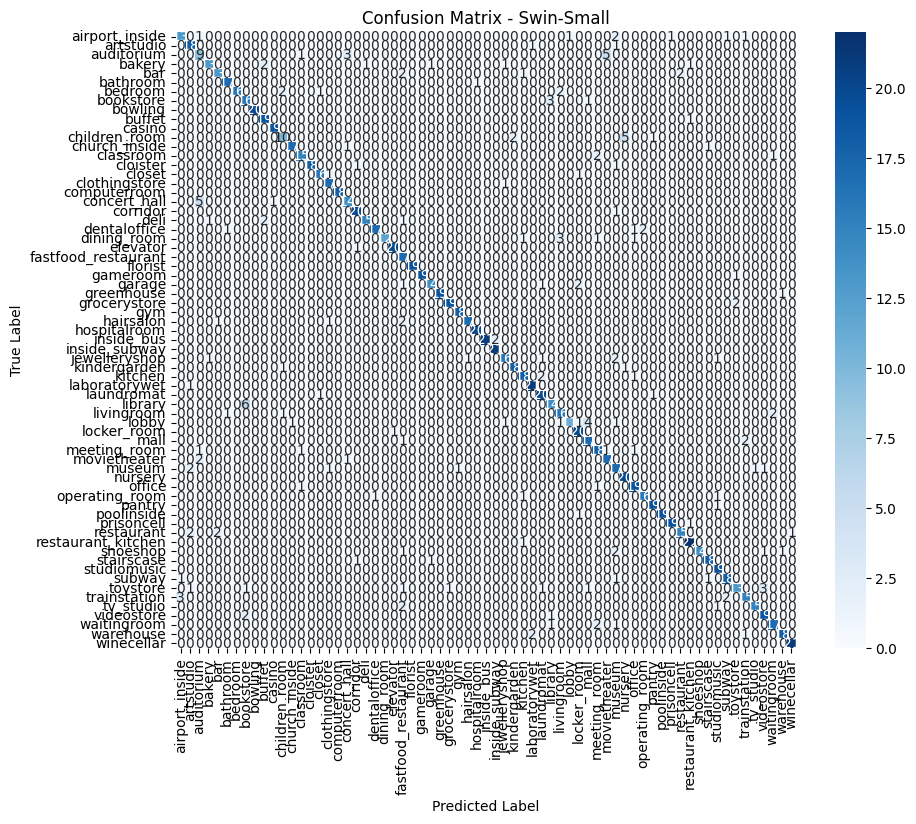

Training Time for Swin-Small: 614.23 seconds

Accuracy for Swin-Small: 8544.7761%



In [ ]:
# Create data loaders with best batch size
train_loader = DataLoader(train_dataset, batch_size=swin_best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=swin_best_params['batch_size'], shuffle=False)

swin_model = timm.create_model(
    "swin_small_patch4_window7_224",
    pretrained=True,
    num_classes=len(class_names),
    drop_rate=swin_best_params['dropout_rate'],
    drop_path_rate=swin_best_params['dropout_rate']/2
)

swin_model, swin_train_acc_history, swin_val_acc_history, swin_time, swin_val_acc = train_model(swin_model, train_loader, val_loader, swin_best_params, num_epochs=10)

# Evaluate
y_true, y_pred, swin_test_acc = evaluate_model(swin_model, test_loader)

# Print classification report
print("Classification Report for Swin-Small:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names, "Swin-Small")

print(f"Training Time for Swin-Small: {swin_time:.2f} seconds\n")
print(f"Accuracy for Swin-Small: {swin_test_acc:.4%}\n")

# Free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

The Swin-Small model achieved 85.44% accuracy with a training time of 614.23 seconds, which is a good balance between ConvNext and ViT in terms of both training time and accuracy.

---

Top 3 best performing categories:
1. Bowling
2. Computer Room
3. Florist


---
Top 3 worst performing categories:
1. Auditorium
2. Children's Room
3. Lobby




## **Step 9: Store Training History**

Here we organize the training history for the 4 models into a dictionary, storing their training accuracy, validation accuracy, training time and test accuracy.

In [ ]:
training_history = {
    "Vision Transformer": {
        "train_acc": vit_train_acc_history,
        "val_acc": vit_val_acc_history,
        "training_time": vit_time,
        "accuracy": vit_test_acc
    },
    "ConvNext": {
        "train_acc": con_train_acc_history,
        "val_acc": con_val_acc_history,
        "training_time": con_time,
        "accuracy": con_test_acc
    },
    "EfficientNet": {
        "train_acc": eff_train_acc_history,
        "val_acc": eff_val_acc_history,
        "training_time": eff_time,
        "accuracy": eff_test_acc
    },
    "Swin-Small": {
        "train_acc": swin_train_acc_history,
        "val_acc": swin_val_acc_history,
        "training_time": swin_time,
        "accuracy": swin_test_acc
    }
}

## **Step 10: Plot Training and Validation History for all models**

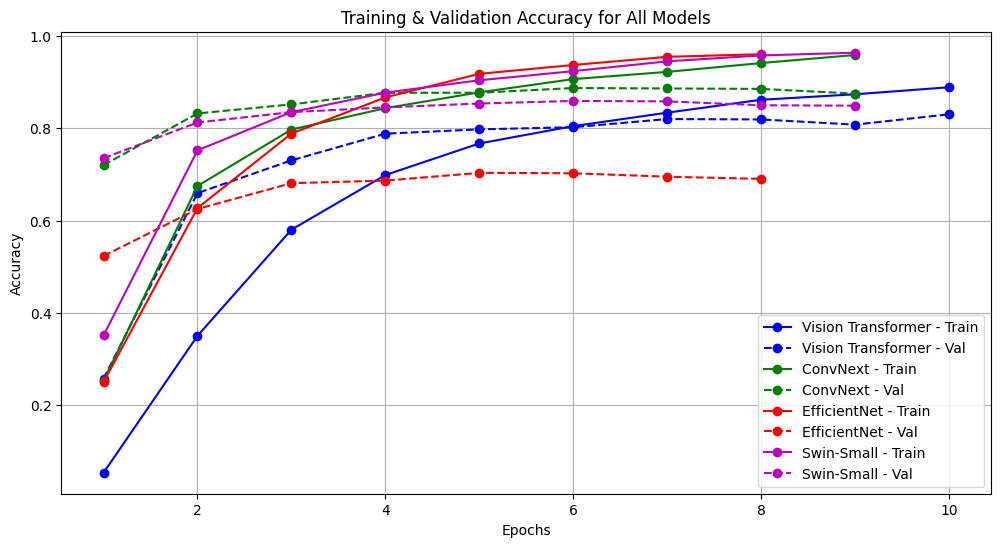


Best Model: ConvNext with Test Accuracy: 87.3881%



In [ ]:
# Plot Training & Validation Accuracy for All Models
plt.figure(figsize=(12, 6))

colors = ['b', 'g', 'r', 'm']

for i, (model_name, history) in enumerate(training_history.items()):
    train_acc = history["train_acc"]
    val_acc = history["val_acc"]
    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_acc, color=colors[i], marker="o", label=f"{model_name} - Train")
    plt.plot(epochs, val_acc, color=colors[i], linestyle="dashed", marker="o", label=f"{model_name} - Val")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy for All Models")
plt.legend()
plt.grid(True)
plt.show()

# Print Best Model
best_model = max(training_history, key=lambda x: training_history[x]["accuracy"])
best_acc = training_history[best_model]["accuracy"]
print(f"\nBest Model: {best_model} with Test Accuracy: {best_acc:.4f}%\n")

The graph titled "Training & Validation Accuracy for All Models" compares the performance of several models during training and validation across different epochs. The models included are Vision Transformer, ConvNext, EfficientNet, and Swin-Small. The epochs range from 0 to 10.

- **Vision Transformer**: Both training and validation accuracy increase steadily with each epoch, indicating that the model is learning effectively without overfitting.

- **ConvNext**: This model shows a significant increase in both training and validation accuracy, reaching the highest test accuracy of 87.1642%. This suggests that ConvNext is the best-performing model among those evaluated.

- **EfficientNet**: The training and validation accuracy for EfficientNet also improve with each epoch, but the rate of improvement is slower compared to ConvNext.

- **Swin-Small**: Similar to the other models, Swin-Small's accuracy increases with each epoch, but it does not surpass the performance of ConvNext.

Overall, ConvNext stands out as the best model with the highest test accuracy, indicating it generalizes well to unseen data. The consistent increase in accuracy across epochs for all models suggests that they are learning effectively, with ConvNext leading in performance.

## **Step 11: Training ConvNext on full dataset**

Lastly, we train and evaluate the best model which is ConvNext on the full dataset now.

[I 2025-02-23 09:07:55,071] A new study created in memory with name: no-name-dd966885-a724-4636-a93d-5d45dba29e3e


Optimizing ConvNeXt hyperparameters...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-02-23 09:20:13,344] Trial 0 finished with value: 0.8473208521626856 and parameters: {'learning_rate': 1.0574503545070979e-05, 'weight_decay': 3.2482152515615223e-06, 'dropout_rate': 0.3626896452275462, 'batch_size': 64}. Best is trial 0 with value: 0.8473208521626856.
[I 2025-02-23 09:32:34,996] Trial 1 finished with value: 0.8482892188508715 and parameters: {'learning_rate': 0.00034376208578275867, 'weight_decay': 1.793062662987224e-05, 'dropout_rate': 0.29545442073811323, 'batch_size': 64}. Best is trial 1 with value: 0.8482892188508715.
[I 2025-02-23 09:44:52,649] Trial 2 finished with value: 0.8805681084570691 and parameters: {'learning_rate': 2.7900536958351952e-05, 'weight_decay': 1.921070044542417e-05, 'dropout_rate': 0.16103092279413214, 'batch_size': 64}. Best is trial 2 with val

Epoch 1/20 - Loss: 772.7245 - Train Acc: 51.5824% - Val Acc: 79.1801%
Epoch 2/20 - Loss: 289.9597 - Train Acc: 80.3871% - Val Acc: 85.4099%
Epoch 3/20 - Loss: 192.4899 - Train Acc: 86.0563% - Val Acc: 86.8302%
Epoch 4/20 - Loss: 146.2805 - Train Acc: 88.7992% - Val Acc: 87.7340%
Epoch 5/20 - Loss: 117.3342 - Train Acc: 90.5788% - Val Acc: 88.0891%
Epoch 6/20 - Loss: 97.8234 - Train Acc: 92.3677% - Val Acc: 88.5410%
Epoch 7/20 - Loss: 80.0701 - Train Acc: 93.6887% - Val Acc: 88.8315%
Epoch 8/20 - Loss: 68.1893 - Train Acc: 94.6610% - Val Acc: 88.5087%
Epoch 9/20 - Loss: 56.2204 - Train Acc: 95.7710% - Val Acc: 88.6701%
Epoch 10/20 - Loss: 46.7602 - Train Acc: 96.4774% - Val Acc: 88.7347%
Early stopping triggered.
Test Accuracy: 89.72%
Classification Report for ConvNeXt:
                     precision    recall  f1-score   support

     airport_inside       0.91      0.95      0.93        62
          artstudio       1.00      0.64      0.78        14
         auditorium       0.61      

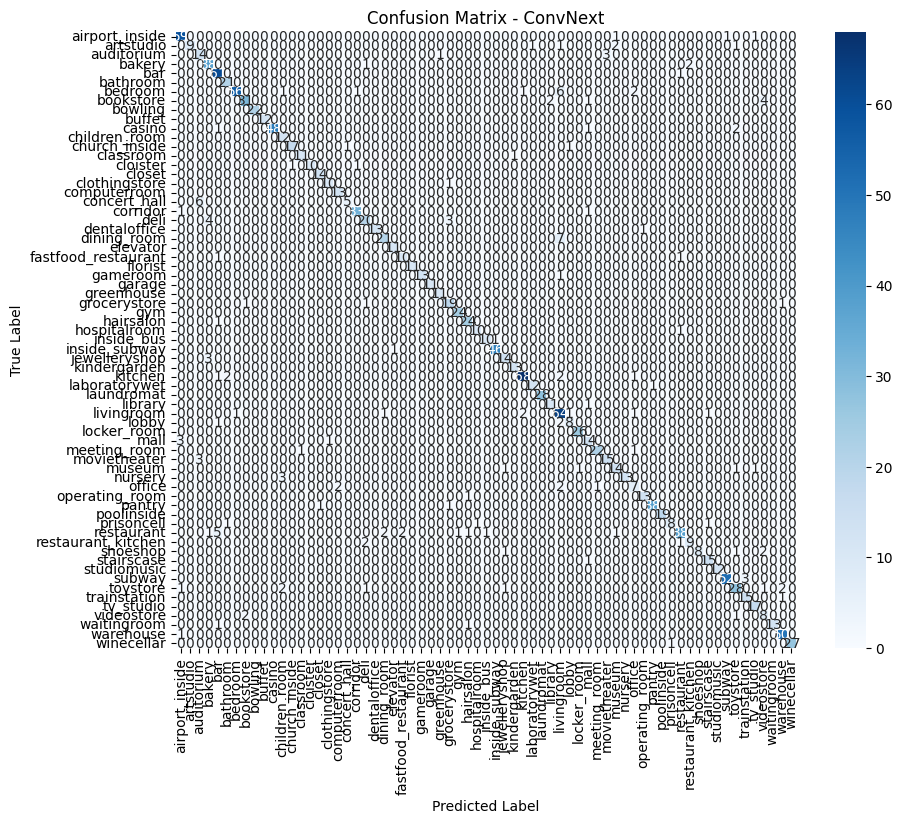

Training Time for ConvNext: 2192.94 seconds

Accuracy for ConvNext: 89.72



In [ ]:
train_dataset = datasets.ImageFolder(root="full_dataset/train", transform=train_transform)
val_dataset = datasets.ImageFolder(root="full_dataset/val", transform=eval_transform)
test_dataset = datasets.ImageFolder(root="full_dataset/test", transform=eval_transform)

# Create data loaders with best batch size
train_loader = DataLoader(train_dataset, batch_size=convnext_best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=convnext_best_params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=convnext_best_params['batch_size'], shuffle=False)

# For ConvNeXt
print("Optimizing ConvNext hyperparameters...")
convnext_study = optuna.create_study(direction='maximize')
convnext_objective = create_objective('convnext_base')
convnext_study.optimize(convnext_objective, n_trials=10)
convnext_best_params = convnext_study.best_params

convnext_model = timm.create_model(
    "convnext_base",
    pretrained=True,
    num_classes=len(class_names),
    drop_rate=convnext_best_params['dropout_rate'],
    drop_path_rate=convnext_best_params['dropout_rate']/2
)

convnext_model, con_train_acc_history, con_val_acc_history, con_time, con_val_acc = train_model(convnext_model, train_loader, val_loader, convnext_best_params, num_epochs=10)

# Evaluate
y_true, y_pred, con_test_acc = evaluate_model(convnext_model, test_loader)

# Print classification report
print("Classification Report for ConvNext:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names, "ConvNext")

print(f"Training Time for ConvNext: {con_time:.2f} seconds\n")
print(f"Accuracy for ConvNext: {con_test_acc:.2f}\n")

This ConvNext model performed best with a final test accuracy of 89.72%.


---
The best trial ahieved 89.09% validation accuracy with:
1. Learning Rate: 2.09e-5
2. Weight Decay: 0.000118
3. Dropout Rate: 0.236
4. Batch Size: 16


---
Key Observations:
1. Early stopping was triggered, meaning the model stopped training once validation performance stopped improving.
2. Final training accuracy was 96.47%, with validation accuracy stabilizing around 88.73% before testing at 89.72%.



In [ ]:
torch.save(convnext_model.state_dict(), 'convnext_model.pth')

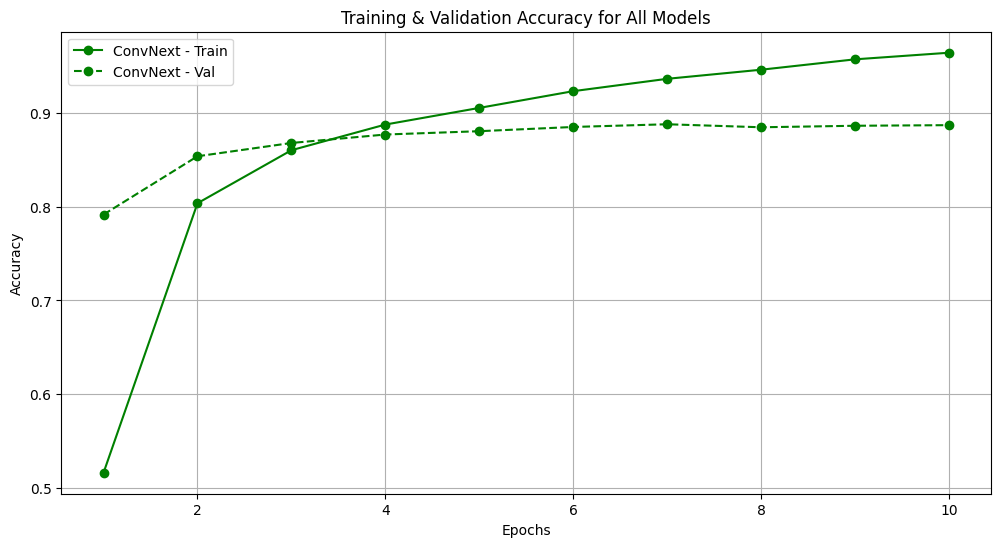

In [ ]:
training_history = {
    "ConvNext": {
        "train_acc": con_train_acc_history,
        "val_acc": con_val_acc_history,
        "training_time": con_time,
        "accuracy": con_test_acc
    }
}

# Plot Training & Validation Accuracy for All Models
plt.figure(figsize=(12, 6))

colors = ['g']

for i, (model_name, history) in enumerate(training_history.items()):
    train_acc = history["train_acc"]
    val_acc = history["val_acc"]
    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_acc, color=colors[i], marker="o", label=f"{model_name} - Train")
    plt.plot(epochs, val_acc, color=colors[i], linestyle="dashed", marker="o", label=f"{model_name} - Val")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy for All Models")
plt.legend()
plt.grid(True)
plt.show()

### **Step 12: Inference**

To test our model on real world examples, we use our saved model to run inference on a set of our own images. Our function code processes each image, then outputs the top 3 predictions inferred from the model.

Place your images in the 'test_images' folder and run this script.
Supported formats: .jpg, .jpeg, .png


<ipython-input-46-24c60f537d78>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Predicting scene for trulli - living room.jpg:
1. livingroom: 95.02%
2. waitingroom: 3.20%
3. bedroom: 0.36%


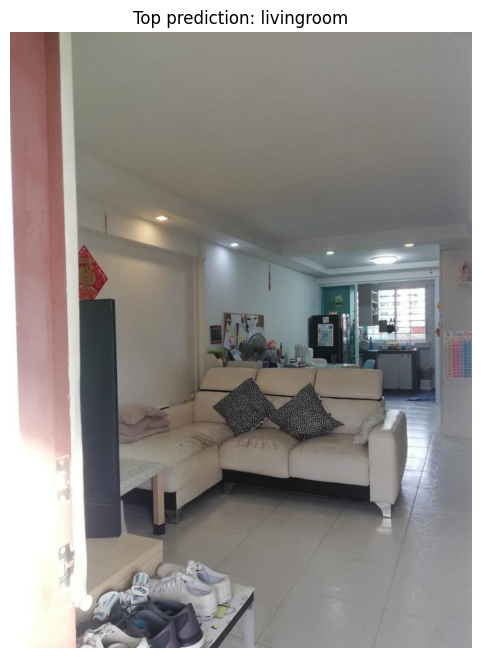


Predicting scene for syabil - dining room.jpg:
1. dining_room: 98.53%
2. meeting_room: 0.79%
3. kitchen: 0.26%


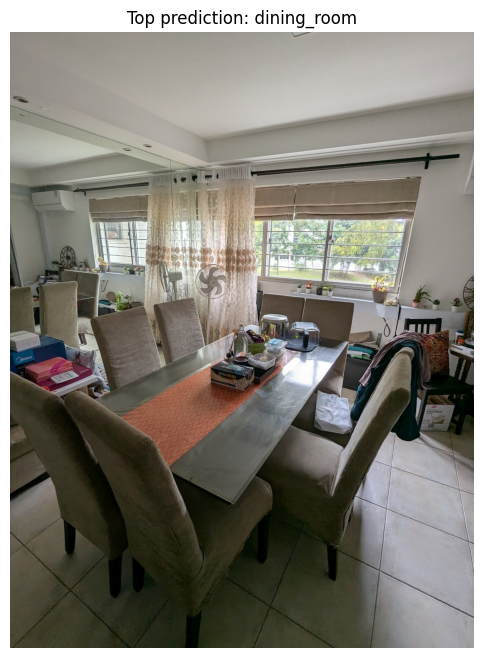


Predicting scene for trulli - bedroom.jpg:
1. bedroom: 96.75%
2. bathroom: 1.29%
3. livingroom: 0.81%


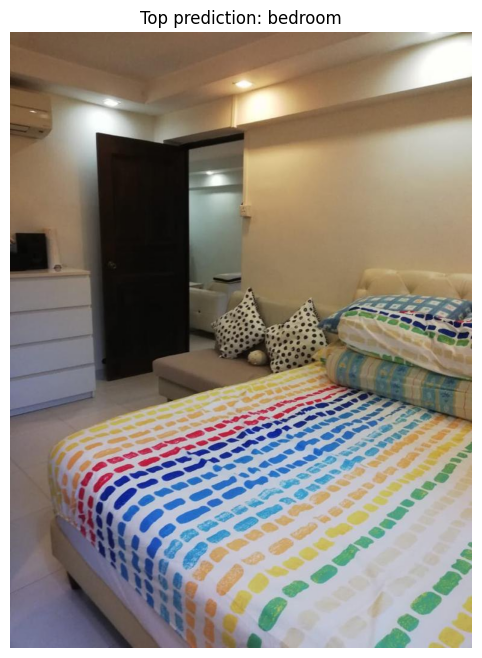


Predicting scene for marcus - living room.jpg:
1. livingroom: 96.11%
2. waitingroom: 1.02%
3. lobby: 0.80%


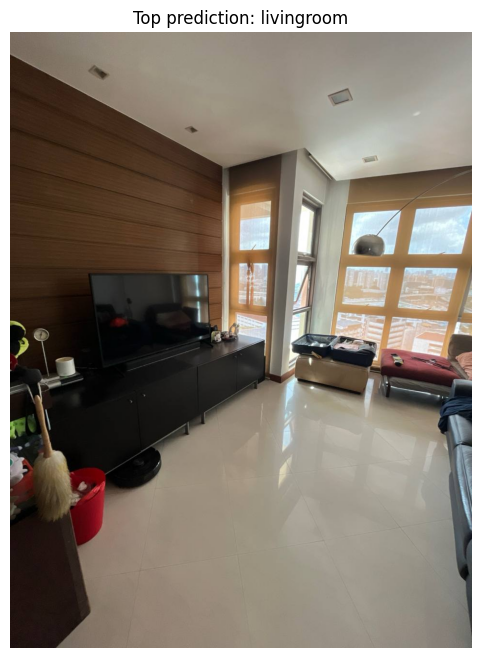

In [ ]:
def predict_scene(model, image_path, class_names):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)

    # Set model to evaluation mode
    model.eval()

    # Get prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

        # Get probabilities
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # Get top 3 predictions
        top3_prob, top3_indices = torch.topk(probabilities, 3)

    # Return results
    results = []
    for prob, idx in zip(top3_prob, top3_indices):
        results.append({
            'class': class_names[idx],
            'probability': prob.item() * 100
        })

    return results

# Example usage:
def test_custom_images(model_path, image_folder):
    # Load the saved model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = timm.create_model("convnext_base", pretrained=False, num_classes=len(class_names))
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Get list of image files
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Process each image
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        print(f"\nPredicting scene for {image_file}:")

        # Get predictions
        predictions = predict_scene(model, image_path, class_names)

        # Display results
        for i, pred in enumerate(predictions, 1):
            print(f"{i}. {pred['class']}: {pred['probability']:.2f}%")

        # Display image
        img = Image.open(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Top prediction: {predictions[0]['class']}")
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Make sure to import required libraries if not already imported
    from PIL import Image
    import os
    import matplotlib.pyplot as plt

    # Specify paths
    MODEL_PATH = 'convnext_model.pth'  # Path to your saved model
    IMAGE_FOLDER = 'test_images'  # Folder containing your test images

    # Create test_images folder if it doesn't exist
    os.makedirs(IMAGE_FOLDER, exist_ok=True)

    print("Place your images in the 'test_images' folder and run this script.")
    print("Supported formats: .jpg, .jpeg, .png")

    # Test the model on your images
    test_custom_images(MODEL_PATH, IMAGE_FOLDER)

The model is able to correctly classify all 4 images that were given to it, with at least 95% confidence for each prediction.